<a href="https://colab.research.google.com/github/johannesmichael/AMLD/blob/main/03_DQN_Tips_%26_Tricks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup
---

Make sure to select GPU in Runtime > Change runtime type > Hardware accelerator

In [ ]:
import sys

# Checks that the Runtime is correct
if 'google.colab' in sys.modules:
    !nvidia-smi | grep -q 'failed' && echo "STOP! You are using a runtime without a GPU. Change the runtime type before going further!"

In [ ]:
!pip install tensorflow==1.15.0

     |████████████████████████████████| 412.3 MB 22 kB/s 
     |████████████████████████████████| 3.8 MB 16.2 MB/s 
     |████████████████████████████████| 503 kB 49.4 MB/s 
     |████████████████████████████████| 50 kB 6.5 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=d3e354071a101153025f31d9fccd1fcc371d3b660e24dde8e19b7767822f7f2d
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.6.0
    Uninstalling tensorboard-2.6.0:
      Successfully uninstalled tensorboard-2.6.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Succes

In [ ]:
import sys

# Setup for use in Colab
# Your Runtime will crash after this - this is normal!
# Resume from next cell after it restarted
if 'google.colab' in sys.modules:
    # Clone GitHub repository
    !git clone https://github.com/AIcrowd/droneRL-workshop

    # Install packages via pip
    !pip install -r "droneRL-workshop/colab-requirements.txt"

    # Restart Runtime so everything takes effect
    import os
    os.kill(os.getpid(), 9)

Cloning into 'droneRL-workshop'...
remote: Enumerating objects: 648, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 648 (delta 49), reused 61 (delta 19), pack-reused 543
Receiving objects: 100% (648/648), 15.03 MiB | 10.41 MiB/s, done.
Resolving deltas: 100% (375/375), done.
     |████████████████████████████████| 1.6 MB 4.1 MB/s 
     |████████████████████████████████| 2.1 MB 32.0 MB/s 
     |████████████████████████████████| 56 kB 4.7 MB/s 
     |████████████████████████████████| 216 kB 54.0 MB/s 
     |████████████████████████████████| 13.1 MB 81 kB/s 
     |████████████████████████████████| 10.4 MB 26.3 MB/s 
     |████████████████████████████████| 20.0 MB 1.5 MB/s 
     |████████████████████████████████| 753.4 MB 6.9 kB/s 
     |████████████████████████████████| 4.0 MB 20.9 MB/s 
     |████████████████████████████████| 1.0 MB 45.5 MB/s 
  Created wheel for gym: filename=gym-0.15.4-py3-none-any.whl size=1648483 s

In [ ]:
%cd droneRL-workshop

/content/droneRL-workshop


Training multiple agents at once
---

In [ ]:
import datetime
import os
import numpy as np

from agents.dqn import DQNAgent, ConvQNetworkFactory, ConvQNetwork
from agents.random import RandomAgent
from agents.logging import TensorBoardLogger, NoLogger
from env.env import DeliveryDrones
from env.wrappers import WindowedGridView
from helpers.rl_helpers import MultiAgentTrainer, test_agents, plot_cumulative_rewards, plot_rolling_rewards, render_video

In [ ]:
env = WindowedGridView(DeliveryDrones(), radius=3)

# Default parameters used for evaluation
env.env_params.update({
    'charge': 20,
    'charge_reward': -0.1,
    'crash_reward': -1,
    'delivery_reward': 1,
    'discharge': 10,
    'drone_density': 0.05,
    'dropzones_factor': 2,
    'n_drones': 10,
    'packets_factor': 3,
    'pickup_reward': 0,
    'rgb_render_rescale': 1.0,
    'skyscrapers_factor': 3,
    'stations_factor': 2
})

In [ ]:
# Setup Tensorboard - wait a bit after running this
%load_ext tensorboard

In [ ]:
# Show Tensorboard. It will take time to appear and will initially be empty
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 185), started 0:03:58 ago. (Use '!kill 185' to kill it.)

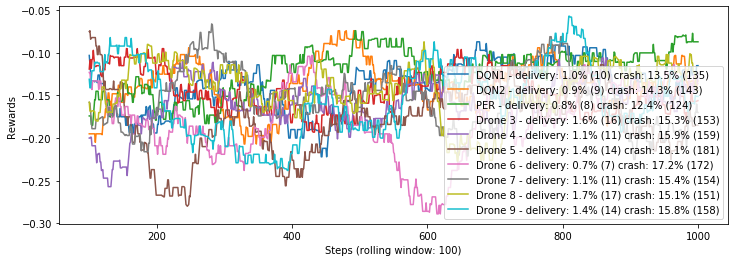

In [ ]:
# Setup TensorBoard loggers
tb_logger_1 = TensorBoardLogger(os.path.join('logs', 'dqn1'), datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
tb_logger_2 = TensorBoardLogger(os.path.join('logs', 'dqn2'), datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
tb_logger_3 = TensorBoardLogger(os.path.join('logs', 'dqn3'), datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))

# Create 3 DQN agents with different hyper-parameters and TensorBoard logging
dqn_agent_1 = DQNAgent(
    env, ConvQNetworkFactory(env, conv_layers=[
        {'out_channels': 32, 'kernel_size': 3, 'stride': 2, 'padding': 1},
        {'out_channels': 32, 'kernel_size': 3, 'stride': 1, 'padding': 1},
        {'out_channels': 32, 'kernel_size': 3, 'stride': 1, 'padding': 1},
        {'out_channels': 32, 'kernel_size': 3, 'stride': 1, 'padding': 1},
    ], dense_layers=[256]),
    gamma=0.95, epsilon_start=1, epsilon_decay=0.99, epsilon_end=0.01, memory_size=10000, batch_size=64,
    target_update_interval=500, logger=tb_logger_1)

dqn_agent_2 = DQNAgent(
    env, ConvQNetworkFactory(env, conv_layers=[
        {'out_channels': 32, 'kernel_size': 3, 'stride': 2, 'padding': 1},
        {'out_channels': 64, 'kernel_size': 3, 'stride': 1, 'padding': 1}
    ], dense_layers=[64, 64]),
    gamma=0.99, epsilon_start=1, epsilon_decay=0.99, epsilon_end=0.01, memory_size=10000, batch_size=64,
    target_update_interval=500, logger=tb_logger_2)

dqn_agent_3 = DQNAgent(
    env, ConvQNetworkFactory(env, conv_layers=[
        {'out_channels': 64, 'kernel_size': 3, 'stride': 1, 'padding': 1}
    ], dense_layers=[16, 16]),
    gamma=0.99, epsilon_start=1, epsilon_decay=0.99, epsilon_end=0.01, memory_size=10000, batch_size=64,
    target_update_interval=500, logger=tb_logger_3)

# Reset environment with those parameters
env.reset()

# Setup random opponents
agents = {drone.index: RandomAgent(env) for drone in env.drones}

# Add the RL drones
agents[0] = dqn_agent_1
agents[1] = dqn_agent_2
agents[2] = dqn_agent_3

# Create trainer
trainer = MultiAgentTrainer(env, agents, reset_agents=True, seed=0)

# Let's train!
trainer.train(1000)
rewards = plot_rolling_rewards(trainer.rewards_log, drones_labels={0: 'DQN1', 1: 'DQN2', 2: 'PER'})



In [ ]:
trainer.train(10000)

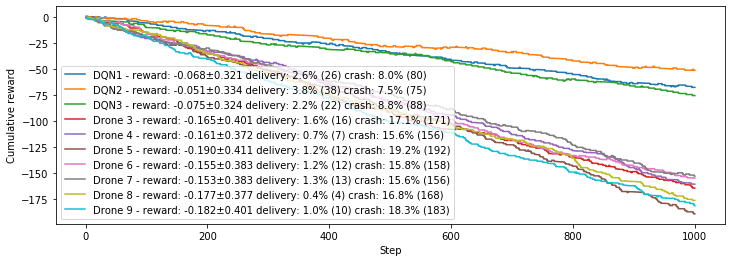

Final scores:
Agent 0: -67.6
Agent 1: -51.2
Agent 2: -75.5
Agent 3: -164.70000000000002
Agent 4: -160.90000000000003
Agent 5: -189.6
Agent 6: -155.0
Agent 7: -153.2
Agent 8: -176.6
Agent 9: -181.60000000000002


In [ ]:
# Evaluation
rewards_log = test_agents(env, agents, n_steps=1000)
plot_cumulative_rewards(rewards_log, drones_labels={0: 'DQN1', 1: 'DQN2', 2: 'DQN3'})

print('Final scores:')
for idx, score in enumerate(np.sum(list(rewards_log.values()), axis=1)):
    print("Agent {}: {}".format(idx, score))

In [ ]:
# Save the agents you want
dqn_agent_1.save(os.path.join('output', 'agents', 'dqn-agent-1.pt'))
dqn_agent_2.save(os.path.join('output', 'agents', 'dqn-agent-2.pt'))
dqn_agent_3.save(os.path.join('output', 'agents', 'dqn-agent-3.pt'))

## Submit to AIcrowd! 🚀

> https://www.aicrowd.com/challenges/dronerl